In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight

## Cleaning the match summary dataset for data imputation

The goal of this notebook is to fill the missing values from multiple columns using median imputation

In [2]:
# Importing the match summary dataset
match_summary = pd.read_csv("Cleaned_dataset/match_summary.csv")
match_summary.head()

,match,Team,Opponent,Location,Goals,Conceded,ShotsTaken,ShotsConceded,Corners,CornersConceded,Foul,Yellow,Red,Possession,OpponentPossession,TeamFormation,OpponentFormation,TeamField,CentreField,OpponentField
0,1,Ajax,FC Groningen,Home,2,1,14.0,11.0,5.0,5.0,15.0,3.0,0.0,57.0,43.0,4-3-3 B,4-3-3 A,23.0,49.0,28.0
1,1,NEC Nijmegen,PEC Zwolle,Home,3,0,16.0,6.0,8.0,4.0,13.0,2.0,0.0,63.0,37.0,4-3-3 A,4-3-3 B,15.0,53.0,32.0
2,1,Sparta Rotterdam,Feyenoord,Home,0,1,9.0,12.0,3.0,3.0,10.0,0.0,0.0,41.0,59.0,4-3-3 A,4-4-2 B,25.0,55.0,20.0
3,1,NAC Breda,RKC Waalwijk,Home,2,0,15.0,5.0,10.0,4.0,11.0,1.0,0.0,62.0,38.0,4-4-2 B,4-3-3 B,16.0,55.0,29.0
4,1,Go Ahead Eagles,AZ,Home,0,0,13.0,7.0,4.0,1.0,16.0,2.0,0.0,60.0,40.0,4-3-3 B,4-3-3 B,18.0,56.0,26.0


In [3]:
# Choosing the necessary columns
match_filtered = match_summary.loc[:, ['ShotsTaken', 'ShotsConceded', 'Corners', 'CornersConceded',
                       'Foul', 'Possession', 'TeamField', 'CentreField']]
match_filtered.head()

,ShotsTaken,ShotsConceded,Corners,CornersConceded,Foul,Possession,TeamField,CentreField
0,14.0,11.0,5.0,5.0,15.0,57.0,23.0,49.0
1,16.0,6.0,8.0,4.0,13.0,63.0,15.0,53.0
2,9.0,12.0,3.0,3.0,10.0,41.0,25.0,55.0
3,15.0,5.0,10.0,4.0,11.0,62.0,16.0,55.0
4,13.0,7.0,4.0,1.0,16.0,60.0,18.0,56.0


In [4]:
# Median of centre field possession
match_filtered['CentreField'].median()

55.0

In [5]:
# Creating a list of variables
varList = match_filtered.columns

In [6]:
# Function to extract the median of each variable
def median_extraction(df):
    return df.median()

# Testing the function
median_extraction(match_filtered)

ShotsTaken         10.0
ShotsConceded      10.0
Corners             5.0
CornersConceded     5.0
Foul               12.0
Possession         50.0
TeamField          22.0
CentreField        55.0
dtype: float64

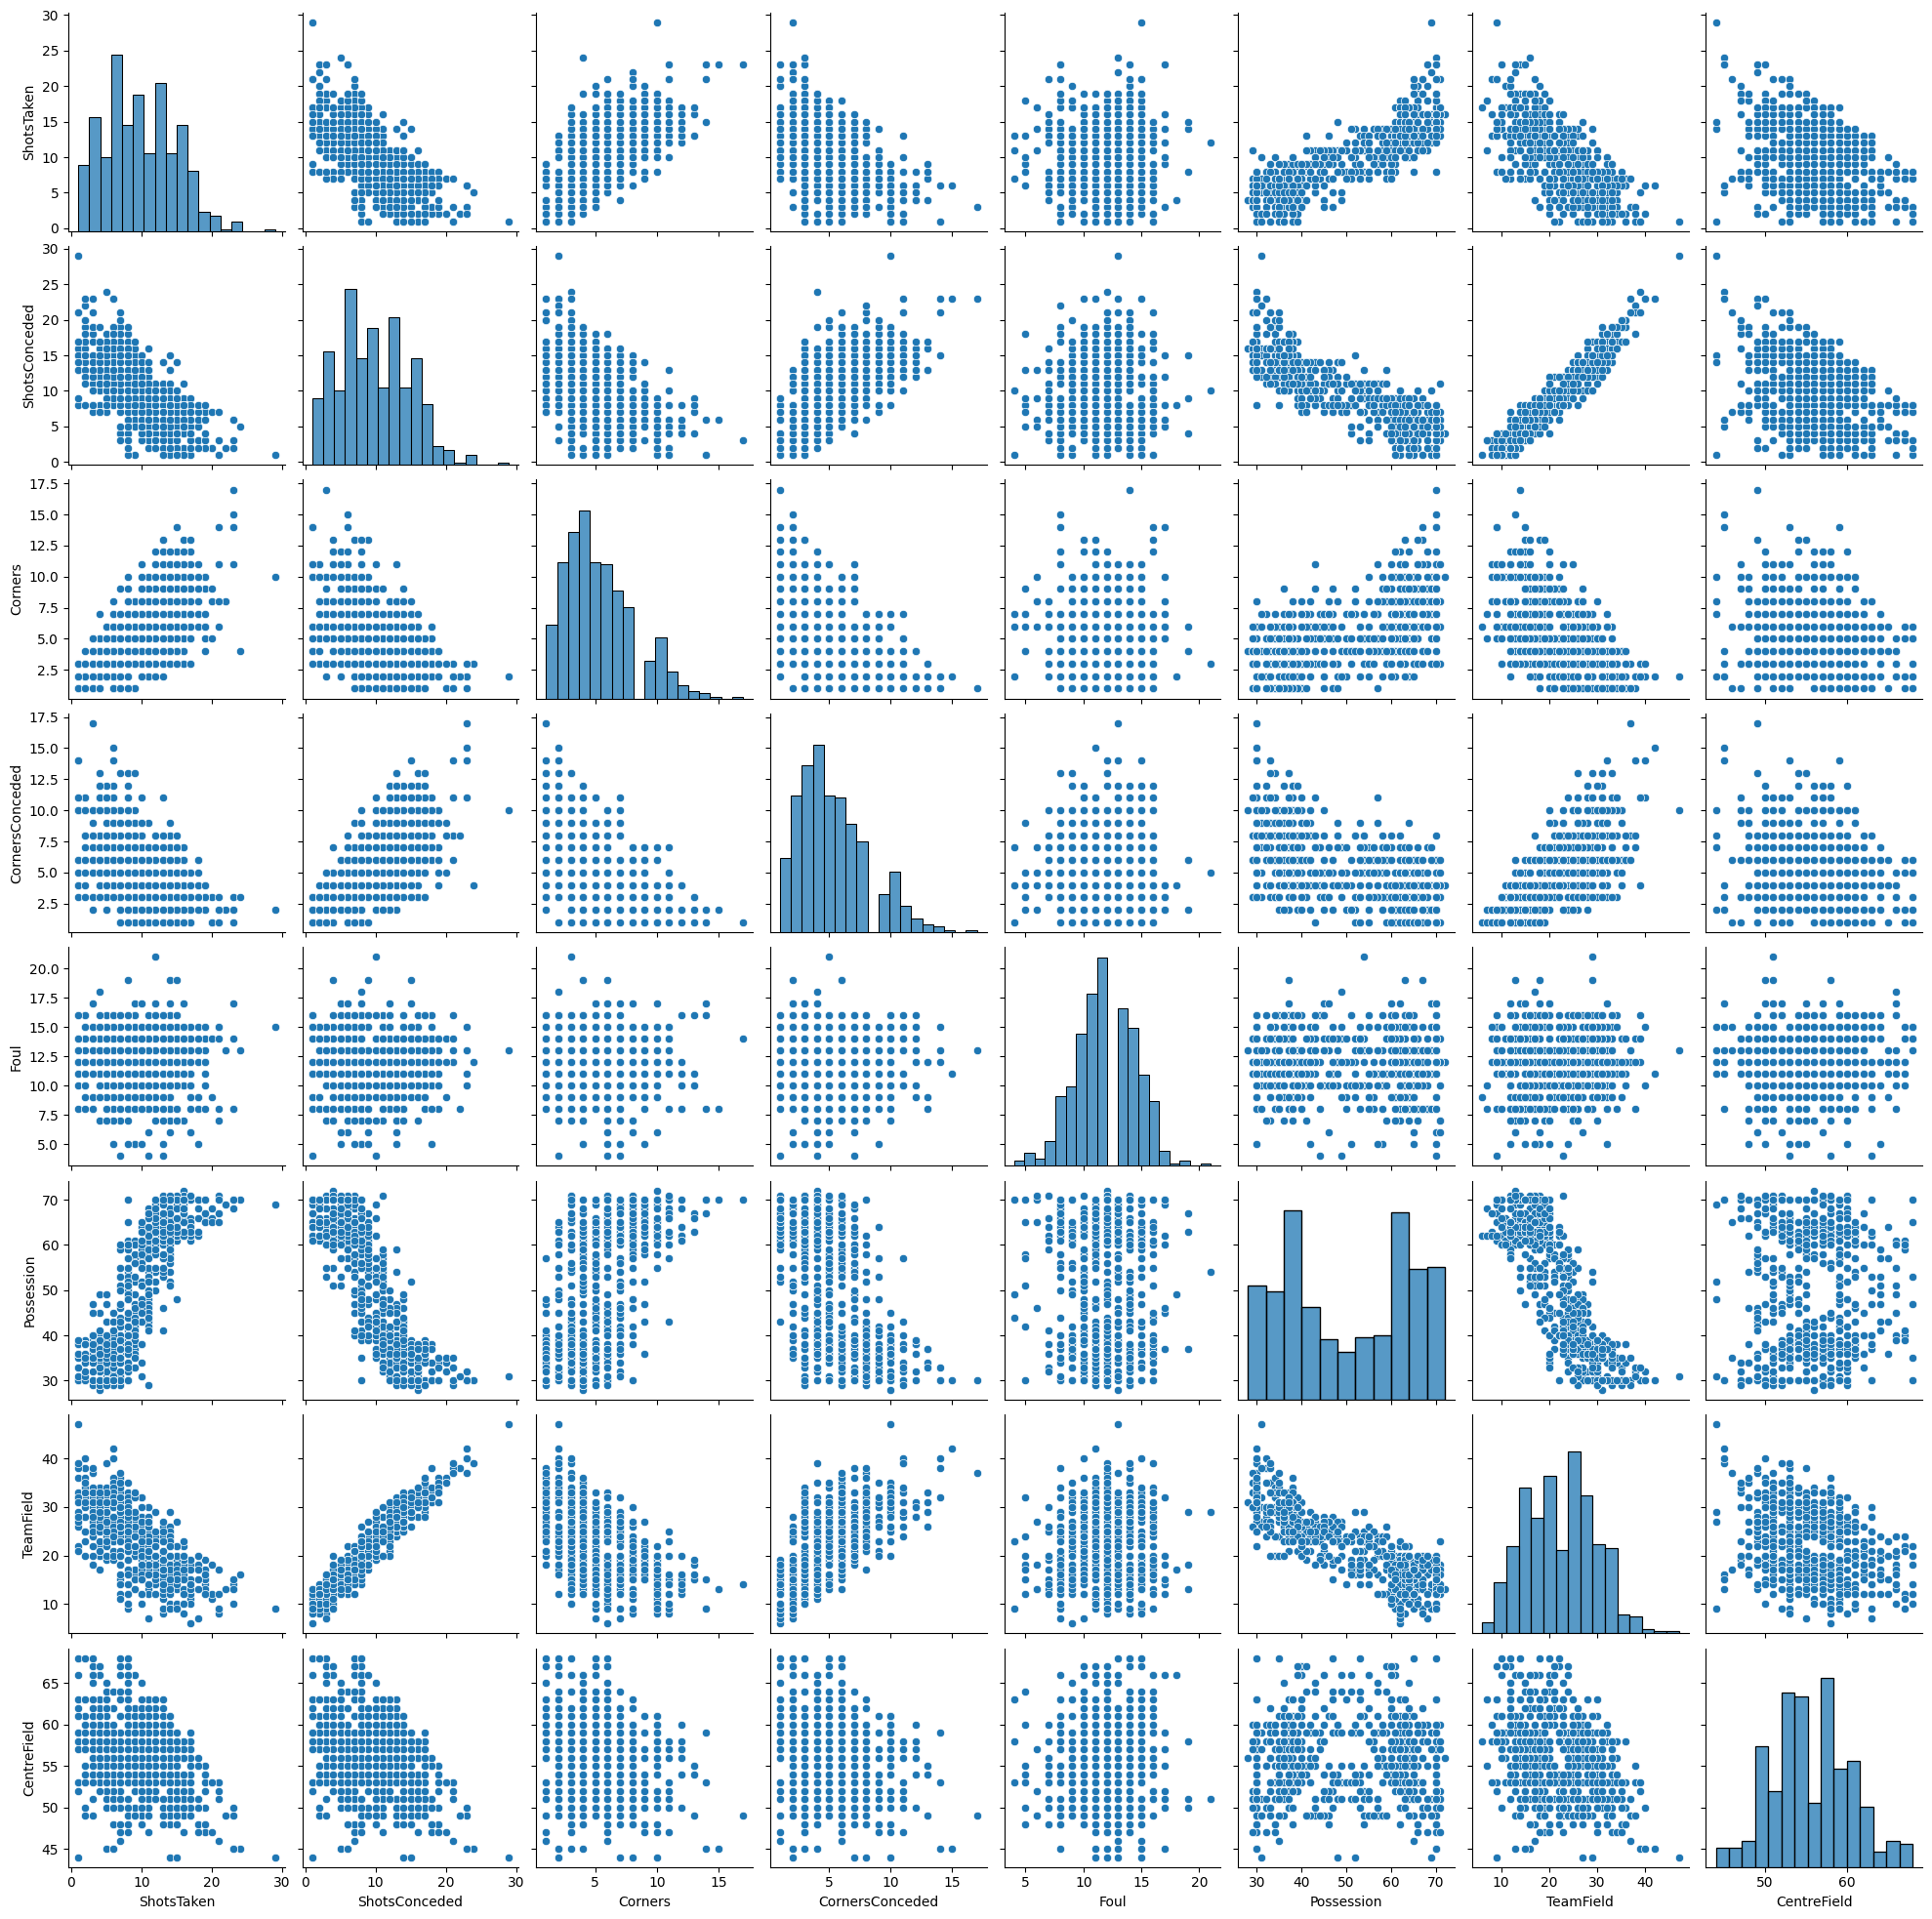

In [7]:
# Plotting to see the distribution of each variable
sns.pairplot(match_filtered)

In [8]:
# Filtering to get the home matches
homeMatch = match_summary[match_summary['Location'] == 'Home']

In [9]:
# Extracting a list of teams
team_list = homeMatch['Team'].unique()
team_list

array(['Ajax', 'NEC Nijmegen', 'Sparta Rotterdam', 'NAC Breda',
       'Go Ahead Eagles', 'Fortuna Sittard', 'FC Utrecht', 'Willem II',
       'Heracles Almelo', 'Almere City', 'AZ', 'RKC Waalwijk',
       'Feyenoord', 'FC Twente', 'PEC Zwolle', 'SC Heerenveen',
       'FC Groningen', 'PSV'], dtype=object)

In [10]:
# List of variables we're interested in
var_list = ['ShotsTaken', 'ShotsConceded', 'Corners', 'CornersConceded',
            'Foul', 'Possession', 'TeamField', 'CentreField']

def match_stats(df, column, team_name):
    
    # Filter the dataframe
    df_filtered = df[(df[column] == team_name) & df[var_list].notna().all(axis=1)][var_list]
    
    if df_filtered.empty:
        print(f"No data found for team: {team_name}")
        return pd.DataFrame()
    
    # Calculate medians
    medians = median_extraction(df_filtered)
    
    # Convert to single-row DataFrame
    result_df = medians.to_frame().T

    # Adding team column
    result_df['Team'] = team_name

    # Reorder columns to have 'Team' first
    cols = ['Team'] + var_list
    result_df = result_df[cols]

    return result_df

# Testing the function
match_stats(homeMatch, 'Team', 'Ajax')

,Team,ShotsTaken,ShotsConceded,Corners,CornersConceded,Foul,Possession,TeamField,CentreField
0,Ajax,13.0,5.0,6.0,3.0,15.0,62.0,14.0,56.0


In [11]:
# Creating an empty dataframe
imputed_df = pd.DataFrame()

# Creatinga  loop to impute data from each team
for team in team_list:
    median_row = match_stats(match_summary, 'Team', team)

    imputed_df = pd.concat([imputed_df, median_row], ignore_index=True)

imputed_df

,Team,ShotsTaken,ShotsConceded,Corners,CornersConceded,Foul,Possession,TeamField,CentreField
0,Ajax,13.0,6.0,6.0,3.0,14.0,62.0,17.0,53.0
1,NEC Nijmegen,13.0,8.0,6.0,4.0,12.0,63.0,19.0,53.0
2,Sparta Rotterdam,5.5,12.0,3.0,6.0,13.0,38.0,26.0,58.0
3,NAC Breda,8.0,11.0,4.0,5.0,12.0,42.5,24.0,56.0
4,Go Ahead Eagles,15.0,7.0,7.0,4.0,10.0,65.0,18.0,51.0
5,Fortuna Sittard,8.0,10.0,4.0,5.0,12.0,47.0,26.5,55.5
6,FC Utrecht,11.0,9.0,5.0,5.0,12.0,57.0,21.0,54.0
7,Willem II,14.0,7.0,6.0,4.0,12.0,62.0,17.0,52.0
8,Heracles Almelo,8.0,11.5,4.5,4.5,12.0,40.0,23.5,57.0
9,Almere City,6.0,11.0,3.0,6.5,12.0,37.0,26.5,59.0


In [12]:
imputed_df.loc[imputed_df['Team'] == 'Ajax', 'ShotsTaken'].values[0]

13.0

In [13]:
# Creating a loop to perform median imputation
for team in team_list:
    for col in varList:
        match_summary.loc[(match_summary['Team'] == team) & 
                          (match_summary[col].isna()),col] = imputed_df.loc[imputed_df['Team'] == team, col].values[0]
        print(f'{team}- changing {col}')

Ajax- changing ShotsTaken
Ajax- changing ShotsConceded
Ajax- changing Corners
Ajax- changing CornersConceded
Ajax- changing Foul
Ajax- changing Possession
Ajax- changing TeamField
Ajax- changing CentreField
NEC Nijmegen- changing ShotsTaken
NEC Nijmegen- changing ShotsConceded
NEC Nijmegen- changing Corners
NEC Nijmegen- changing CornersConceded
NEC Nijmegen- changing Foul
NEC Nijmegen- changing Possession
NEC Nijmegen- changing TeamField
NEC Nijmegen- changing CentreField
Sparta Rotterdam- changing ShotsTaken
Sparta Rotterdam- changing ShotsConceded
Sparta Rotterdam- changing Corners
Sparta Rotterdam- changing CornersConceded
Sparta Rotterdam- changing Foul
Sparta Rotterdam- changing Possession
Sparta Rotterdam- changing TeamField
Sparta Rotterdam- changing CentreField
NAC Breda- changing ShotsTaken
NAC Breda- changing ShotsConceded
NAC Breda- changing Corners
NAC Breda- changing CornersConceded
NAC Breda- changing Foul
NAC Breda- changing Possession
NAC Breda- changing TeamField
NAC 

In [15]:
# Checking to see whether the missing values are filled
match_summary[match_summary['Location'] == "Home"]

,match,Team,Opponent,Location,Goals,Conceded,ShotsTaken,ShotsConceded,Corners,CornersConceded,Foul,Yellow,Red,Possession,OpponentPossession,TeamFormation,OpponentFormation,TeamField,CentreField,OpponentField
0,1,Ajax,FC Groningen,Home,2,1,14.0,11.0,5.0,5.0,15.0,3.0,0.0,57.0,43.0,4-3-3 B,4-3-3 A,23.0,49.0,28.0
1,1,NEC Nijmegen,PEC Zwolle,Home,3,0,16.0,6.0,8.0,4.0,13.0,2.0,0.0,63.0,37.0,4-3-3 A,4-3-3 B,15.0,53.0,32.0
2,1,Sparta Rotterdam,Feyenoord,Home,0,1,9.0,12.0,3.0,3.0,10.0,0.0,0.0,41.0,59.0,4-3-3 A,4-4-2 B,25.0,55.0,20.0
3,1,NAC Breda,RKC Waalwijk,Home,2,0,15.0,5.0,10.0,4.0,11.0,1.0,0.0,62.0,38.0,4-4-2 B,4-3-3 B,16.0,55.0,29.0
4,1,Go Ahead Eagles,AZ,Home,0,0,13.0,7.0,4.0,1.0,16.0,2.0,0.0,60.0,40.0,4-3-3 B,4-3-3 B,18.0,56.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,39,FC Groningen,Go Ahead Eagles,Home,2,2,9.5,9.0,6.0,4.0,7.0,NaN,NaN,51.5,NaN,4-3-3 A,4-3-3 B,19.0,55.0,NaN
319,39,PSV,NEC Nijmegen,Home,1,2,11.0,8.0,5.0,4.0,12.0,NaN,NaN,60.0,NaN,4-3-3 A,4-3-3 A,20.0,53.0,NaN
320,39,FC Utrecht,AZ,Home,1,0,11.0,9.0,5.0,5.0,12.0,NaN,NaN,57.0,NaN,4-3-3 A,4-3-3 A,21.0,54.0,NaN
321,39,Willem II,FC Twente,Home,3,1,14.0,7.0,6.0,4.0,12.0,NaN,NaN,62.0,NaN,4-3-3 A,4-4-2 B,17.0,52.0,NaN


#### The remainder of this data cleaning is to use the player rating dataset to fill in the yellow and red card columns

In [19]:
# Importing the player rating dataset
rating = pd.read_csv("D:\Webscraping\Eridivisie\Cleaned_dataset\Ready\playerRating.csv")
rating.head()

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
C:\Users\hoybr\AppData\Local\Temp\ipykernel_21920\2826958999.py:2: SyntaxWarning: invalid escape sequence '\W'
  rating = pd.read_csv("D:\Webscraping\Eridivisie\Cleaned_dataset\Ready\playerRating.csv")


,Match,Game,Team,Opponent_x,Home_or_Away,Name,Rating,goal,yellowcard,redcard,...,penaltygoal,penaltymiss,sub,Outcome,Player of the Match,TeamGoals,Conceded,Assist,Position,Value
0,1,1,FC Groningen,Ajax,Away,Verbruggen,5,0,0,0,...,0,0,0,L,0,1,2,0,GK,3800000.0
1,1,1,FC Groningen,Ajax,Away,Benedetti,7,0,0,0,...,0,0,0,L,0,1,2,1,LB,3200000.0
2,1,1,FC Groningen,Ajax,Away,Gabriel Paulista,6,0,0,0,...,0,0,0,L,0,1,2,0,CB,3000000.0
3,1,1,FC Groningen,Ajax,Away,Thiaw,6,0,0,0,...,0,0,0,L,0,1,2,0,CB,4800000.0
4,1,1,FC Groningen,Ajax,Away,Dedic,5,0,1,0,...,0,0,0,L,0,1,2,0,RB,4700000.0


In [25]:
# Getting yellow cards
match = rating[rating['Match'] == 39].groupby(['Match', 'Team', 'Opponent_x'])[['yellowcard', 'redcardsecondyellow']].sum().reset_index()
match['total_cards'] = match['yellowcard'] + match['redcardsecondyellow']

# Extracting total yellow cards
match.loc[(match['Team'] == 'Ajax'), 'total_cards'].values[0]
match.sample(3)

,Match,Team,Opponent_x,yellowcard,redcardsecondyellow,total_cards
7,39,Fortuna Sittard,Heracles Almelo,0,0,0
2,39,Almere City,Ajax,1,0,1
13,39,PSV,NEC Nijmegen,1,1,2


In [29]:
# Creating a loop to perform median imputation
for team in team_list:
    # Check if the team exists in the match DataFrame
    team_data = match.loc[match['Team'] == team, 'total_cards']
    
    if not team_data.empty:
        total_cards = team_data.values[0]
    else:
        # If no data for this team, you might want to set a default value or skip
        total_cards = 0  # or whatever default value makes sense
    
    # Extracting total yellow cards
    match_summary.loc[(match_summary['Team'] == team) & 
                      (match_summary['Yellow'].isna()), 'Yellow'] = total_cards
    
    print(f'{team}: {total_cards}')

Ajax: 1
NEC Nijmegen: 2
Sparta Rotterdam: 0
NAC Breda: 2
Go Ahead Eagles: 2
Fortuna Sittard: 0
FC Utrecht: 0
Willem II: 2
Heracles Almelo: 1
Almere City: 1
AZ: 0
RKC Waalwijk: 0
Feyenoord: 2
FC Twente: 2
PEC Zwolle: 2
SC Heerenveen: 2
FC Groningen: 0
PSV: 2


#### Doing the same process for red cards

In [31]:
# Getting red cards
match = rating[rating['Match'] == 39].groupby(['Match', 'Team', 'Opponent_x'])[['redcard', 'redcardsecondyellow']].sum().reset_index()
match['total_cards'] = match['redcard'] + match['redcardsecondyellow']

# Extracting total yellow cards
match.head()

,Match,Team,Opponent_x,redcard,redcardsecondyellow,total_cards
0,39,AZ,FC Utrecht,0,0,0
1,39,Ajax,Almere City,0,0,0
2,39,Almere City,Ajax,1,0,1
3,39,FC Groningen,Go Ahead Eagles,0,0,0
4,39,FC Twente,Willem II,0,0,0


In [32]:
# Creating a loop to perform median imputation
for team in team_list:
    # Check if the team exists in the match DataFrame
    team_data = match.loc[match['Team'] == team, 'total_cards']
    
    if not team_data.empty:
        total_cards = team_data.values[0]
    else:
        # If no data for this team, you might want to set a default value or skip
        total_cards = 0  # or whatever default value makes sense
    
    # Extracting total yellow cards
    match_summary.loc[(match_summary['Team'] == team) & 
                      (match_summary['Red'].isna()), 'Red'] = total_cards
    
    print(f'{team}: {total_cards}')

Ajax: 0
NEC Nijmegen: 1
Sparta Rotterdam: 0
NAC Breda: 0
Go Ahead Eagles: 0
Fortuna Sittard: 0
FC Utrecht: 0
Willem II: 0
Heracles Almelo: 0
Almere City: 1
AZ: 0
RKC Waalwijk: 0
Feyenoord: 2
FC Twente: 0
PEC Zwolle: 0
SC Heerenveen: 0
FC Groningen: 0
PSV: 1


In [ ]:
# Exporting the data
match_summary.to_csv("D:\Webscraping\Eridivisie\Cleaned_dataset\match_summary_cleaned.csv", index=False)